To run distributed:

```
make
```

```
CUDA_VISIBLE_DEVICES=3,4,5,1,2,0 python -m torch.distributed.launch --master_port 1235 --nproc_per_node=6 02_train.py --epochs 30 --bs 96 --fp16 to_fp16 --trf_heads 4 --mixup False --chunk_size 500 --trf_dim 512 --loss ce --n_chunks 1 --fit fit_flat_cos --fit_kwargs pct_start=0.5 div_final=100 --tfixup True --pad r --valid_pct 0.025 --trf_act gelu --opt ranger_lamb --lr 3e-3
```

In [1]:
import fastai

In [2]:
from fastai.basics       import *
from fastai.callback.all import *
from fastai.distributed  import *
from fastai.tabular.all  import *
from fastai.test_utils   import *

import ast
import enum
import gc
import pandas as pd
import pickle
import enum

from collections import defaultdict
from fastcore.script import *
from matplotlib import pyplot as plt
from pathlib import Path
from pytorch_block_sparse.util import ModelPatcher
from sklearn.metrics import roc_auc_score
from torch.distributions.beta import Beta
from torch.utils.data import Dataset

In [3]:
in_d = Path('input')

In [4]:
@call_parse
def main(
    model:         Param("Name", str) = '210105',
    data:          Param("Data version", str) = '210101b',
    load:          Param("Load from", str) = None,
    validate:      Param("", action='store_true') = False,
    chunk_size:    Param("Chunk size", int) = 500,
    n_chunks:      Param("Number of chunks", int) = 1,
    #chunk_size:    Param("Chunk size", int) = 50,  
    #n_chunks:      Param("Number of chunks", int) = 10,    
    #bs:            Param("BS", int) = 96,
    bs:            Param("BS", int) = 48,    #2 works, 96 doesn't
    workers:       Param("", int) = 8,
    valid_pct:     Param("Validation set", float) = 0.025,
    trf_dim:       Param("", int) = 512,
    trf_enc:       Param("", int) = 4,
    trf_dec:       Param("", int) = 4,
    trf_heads:     Param("", int) = 4,
    trf_do:        Param("", float) = 0.1,
    trf_act:       Param("", str) = 'gelu',
    lr:            Param("", float) = 3e-3,
    clip:          Param("", float) = 0.,
    
    moms:          Param("Moms for fit_one_cycle", float, nargs='+') = (0.95,0.85,0.95),
    epochs:        Param("Epochs", int) = 5, #Original was 30,
    tfixup:        Param("Use T-Fixup init", ast.literal_eval) = True,
    mixup:         Param("Use mixup", ast.literal_eval) = False,
    opt:           Param("Optimizer", str) = 'ranger_lamb',
    opt_kwargs:    Param("Optional args for opt, eg. eps=1e-4", str, nargs='+') = {},
    fit:           Param("fit or fit_one_cycle", str) = 'fit_flat_cos',
    fit_kwargs:    Param("Optional args for fit,eg pct_start=0.1", str, nargs='+') = ['pct_start=0.5', 'div_final=100.'],
    fp16:          Param("fp16 method: to_fp16, to_native_fp16, none", str) = 'to_fp16',
    
    loss:          Param("Loss", str) = 'ce',
    
    wua:           Param("Weight of user_answer term in the loss", float) = 0.,
    pad:           Param ("Pad left of right (l|r)",str,choices=['l','r'])='r',

    local_rank:    Param("--local_rank", int) = None,
): 
    if opt_kwargs: opt_kwargs = {s.split('=')[0]:float(s.split('=')[1]) for s in opt_kwargs}
    if fit_kwargs: fit_kwargs = {s.split('=')[0]:float(s.split('=')[1]) for s in fit_kwargs}
    print(locals())
    globals().update({ 'H' : AttrDict(locals())})
_H = AttrDict

In [5]:
#noexport
main()

{'model': '210105', 'data': '210101b', 'load': None, 'validate': False, 'chunk_size': 500, 'n_chunks': 1, 'bs': 48, 'workers': 8, 'valid_pct': 0.025, 'trf_dim': 512, 'trf_enc': 4, 'trf_dec': 4, 'trf_heads': 4, 'trf_do': 0.1, 'trf_act': 'gelu', 'lr': 0.003, 'clip': 0.0, 'moms': (0.95, 0.85, 0.95), 'epochs': 5, 'tfixup': True, 'mixup': False, 'opt': 'ranger_lamb', 'opt_kwargs': {}, 'fit': 'fit_flat_cos', 'fit_kwargs': {'pct_start': 0.5, 'div_final': 100.0}, 'fp16': 'to_fp16', 'loss': 'ce', 'wua': 0.0, 'pad': 'r', 'local_rank': None}


In [6]:
n_gpus = torch.cuda.device_count() if H.local_rank is None else 1
if H.local_rank is not None:
    torch.cuda.set_device(H.local_rank)
    torch.distributed.init_process_group(backend='nccl', init_method='env://')
    print(f"DISTRIBUTED: {H.local_rank}")

# Read df and meta

In [7]:
#TODO detect if meta exists and don't load it.

In [8]:
with open(in_d / f'meta_v{H.data}.pkl', 'rb') as f:
    meta = pickle.load(f)

In [9]:
QCols = enum.IntEnum('QCols', meta.qcols, start=0)
LCols = enum.IntEnum('LCols', meta.lcols, start=0)
Cats  = enum.IntEnum('Cats',  meta.cat_names, start=0)
Conts = enum.IntEnum('Conts', meta.cont_names, start=0)

In [10]:
#%%time
with open(in_d / f'data_v{H.data}.pkl', 'rb') as f:
    data = pickle.load(f)

In [11]:
#TODO detect if data exists and don't load it.

In [12]:
del data.attempt_num_coo
del data.attempts_correct_coo
gc.collect()

46

# Y

In [13]:
lut = meta.icats['answered_correctly'],meta.icats['user_answer']
y_d = {}
for k, v in data.cat_d.items():
    y_d[k] = np.column_stack((lut[0][v[:,Cats.answered_correctly] - 1],lut[1][v[:,Cats.user_answer] - 1]))

# Chop sequences

In [14]:
def chop_sequence(d):
    nv = defaultdict(dict)
    for k, v in d.items():
        i = 0
        while i*H.chunk_size < len(v):
            nv[k][i] = v[i*H.chunk_size:(i+1)*H.chunk_size]
            i += 1
    return nv

In [15]:
cat_d  = chop_sequence(data.cat_d)
cont_d = chop_sequence(data.cont_d)
tags_d = chop_sequence(data.tags_d)
tagw_d = chop_sequence(data.tagw_d)
y_d    = chop_sequence(y_d)

In [16]:
#assert np.concatenate(list(cat_d.values())).shape[0] == np.concatenate(list(data.cat_d.values())).shape[0]

In [17]:
print(f'There are {len(data.cat_d)} different users')

There are 393656 different users


# Train/valid split

In [18]:
group_keys = sorted(list(cat_d.keys()))

In [19]:
# Last H.valid_pct is valid set
train_group_keys = group_keys[:int((1 - H.valid_pct) * len(group_keys))]
valid_group_keys = group_keys[int((1 - H.valid_pct) * len(group_keys)):]

In [20]:
print(f'users: train={len(train_group_keys)}, valid={len(valid_group_keys)}')

users: train=383814, valid=9842


# Data

## To dicts

In [21]:
def split_dict(d, keys):
    return { (u, t): d[u][t] for u in keys for t in d[u].keys() }

In [22]:
train_x_cat =  split_dict(cat_d, train_group_keys)
train_x_cont = split_dict(cont_d, train_group_keys)
train_x_tags = split_dict(tags_d, train_group_keys)
train_x_tagw = split_dict(tagw_d, train_group_keys)
train_y =      split_dict(y_d, train_group_keys)

In [23]:
valid_x_cat =  split_dict(cat_d, valid_group_keys)
valid_x_cont = split_dict(cont_d, valid_group_keys)
valid_x_tags = split_dict(tags_d, valid_group_keys)
valid_x_tagw = split_dict(tagw_d, valid_group_keys)
valid_y =      split_dict(y_d, valid_group_keys)

In [24]:
print(f'seqs: train={len(train_x_cat)}, valid={len(valid_x_cat)}')

seqs: train=507050, valid=12914


# Dataset

In [25]:
class InteractionsDataset(Dataset):
    def __init__(self, x_cat, x_cont, x_tags, x_tagw, y, minids=False):
        super().__init__()
        
        self.means = np.expand_dims(meta.means, axis=0) # ready to broadcast
        self.stds  = np.expand_dims(meta.stds , axis=0)
        
        self.n_inp = 5  # number of feature (x) tensors
        
        self.x_cat = x_cat  # SL, XF (sequence len, feature columns) 
        self.x_cont = x_cont
        self.x_tags = x_tags      
        self.x_tagw = x_tagw
        self.y = y  # SL, 1
        
        self.keys = list(self.x_cat.keys()) # list of group keys
        
        if minids:
            self.keys = self.keys[:H.bs*2]

    def __len__(self):
        return len(self.keys) # H.bs * 2

    def __getitem__(self, idx):
        user_id, time_slice = self.keys[idx]
        win = range(max(0, time_slice - H.n_chunks + 1), time_slice + 1)
        x_cat  = np.concatenate([ self.x_cat [(user_id, ts)] for ts in win ])
        x_cont = np.concatenate([ self.x_cont[(user_id, ts)] for ts in win ])
        x_tags = np.concatenate([ self.x_tags[(user_id, ts)] for ts in win ])
        x_tagw = np.concatenate([ self.x_tagw[(user_id, ts)] for ts in win ])
        y      = np.concatenate([ self.y     [(user_id, ts)] for ts in win ])
        
        pad = H.chunk_size * H.n_chunks - x_cat.shape[0]
        
        # Normalize x_cont
        x_cont = (x_cont - self.means) / self.stds
        x_cont[np.isnan(x_cont)] = 0
        
        padt = (0,pad) if H.pad == 'r' else (pad,0)
        
        x_mask = np.zeros(x_cat.shape[0], dtype=np.bool)
        
        x_mask = np.pad(x_mask, padt, constant_values=(True))
        x_cat  = np.pad(x_cat , (padt, (0, 0)), constant_values=(0)).astype(np.int64)
        x_cont = np.pad(x_cont, (padt, (0, 0)), constant_values=(0)).astype(np.float32)
        x_tags = np.pad(x_tags, (padt, (0, 0)), constant_values=(0)).astype(np.int64)
        x_tagw = np.pad(x_tagw, (padt, (0, 0)), constant_values=(0.)).astype(np.float32)
        y      = np.pad(y,      (padt, (0, 0)), constant_values=(-1)).astype(np.int64)

        return x_mask, x_cat, x_cont, x_tags, x_tagw, y

In [26]:
train_ds = InteractionsDataset(train_x_cat, train_x_cont, train_x_tags, train_x_tagw, train_y)
valid_ds = InteractionsDataset(valid_x_cat, valid_x_cont, valid_x_tags, valid_x_tagw, valid_y)

In [27]:
x_mask, x_cat, x_cont, x_tags, x_tagw, y = train_ds[0]

In [28]:
len(train_ds.keys)

507050

In [29]:
#x_tagw[-47:]

In [30]:
assert x_cat.shape == (H.chunk_size*H.n_chunks, len(meta.cat_names))
assert x_cont.shape == (H.chunk_size*H.n_chunks, len(meta.cont_names))
assert x_tags.shape == x_tagw.shape == (H.chunk_size*H.n_chunks, 6)
assert y.shape == (H.chunk_size*H.n_chunks, 2)

In [31]:
train_dl = DataLoader(train_ds, bs=H.bs, shuffle=True, drop_last=True, num_workers=H.workers)
valid_dl = DataLoader(valid_ds, bs=H.bs,                               num_workers=H.workers)

In [32]:
dls = DataLoaders(train_dl, valid_dl)

In [33]:
x_mask,x_cat, x_cont, x_tags, x_tagw, y = dls.one_batch()

In [34]:
np.set_printoptions(precision=4, suppress=True)
torch.set_printoptions(precision=4, linewidth=200, sci_mode=False)

In [35]:
x_cont[1]

tensor([[-0.2928, -0.3581, -0.1834,  ..., -0.0769,  0.0000,  0.0000],
        [-0.2928, -0.3581, -0.1834,  ..., -0.0765, -0.0427, -0.5176],
        [-0.2928, -0.3581, -0.1834,  ..., -0.0760, -0.0427, -0.4131],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [36]:
x_cat.shape, x_cont.shape, x_tags.shape, x_tagw.shape, y.shape

(torch.Size([48, 500, 11]),
 torch.Size([48, 500, 23]),
 torch.Size([48, 500, 6]),
 torch.Size([48, 500, 6]),
 torch.Size([48, 500, 2]))

In [37]:
assert x_cat.isnan().any() == False
assert x_cont.isnan().any() == False
assert x_tags.isnan().any() == False
assert x_tagw.isnan().any() == False

In [38]:
assert x_cat.shape == (H.bs, H.chunk_size*H.n_chunks, len(meta.cat_names))
assert x_cont.shape == (H.bs, H.chunk_size*H.n_chunks, len(meta.cont_names))
assert x_tags.shape == x_tagw.shape == (H.bs, H.chunk_size*H.n_chunks, 6)
assert y.shape == (H.bs, H.chunk_size*H.n_chunks, 2)

# Loss and metrics

In [39]:
def roc_auc(pred, targ):
    pred = torch.softmax(pred, dim=2)
    pred = pred[:,:,1:2] # prediction for True
    idx = targ != -1
    pred = pred[idx]
    targ = targ[idx]
    pred, targ = flatten_check(pred, targ)
    if len(targ.unique()) == 2:
        return roc_auc_score(targ.cpu().numpy(), pred.cpu().numpy())
    else:
        return 0

In [40]:
loss_fn = nn.CrossEntropyLoss if H.loss=='ce' else globals()[H.loss]
loss    = loss_fn(ignore_index=-1)
loss_nr = loss_fn(ignore_index=-1, reduction='none')

def loss_func(pred, targ, shuffle=None, lam=None):
    b, s, l = pred.shape
    if shuffle is not None:
        targ_shuffled = targ[shuffle].view(b*s)
    pred = pred.view(b*s, l)
    targ = targ.view(b*s)

    if shuffle is not None:
        l0 = loss_nr(pred, targ).view(b, s)
        l1 = loss_nr(pred, targ_shuffled).view(b, s)
        return torch.lerp(l0, l1, lam.view(lam.shape[0], 1)).mean()
    else:
        #print(targ.unique()) # CUDA assert error if any index here is bigger than dimension l (labels) of pred
        return loss(pred, targ)
    
def ua_loss_func(pred, targ, shuffle=None, lam=None):
    loss_fn = loss_func
    l = loss_fn(pred[...,:2],targ[...,:1],shuffle,lam) 
    if H.wua and targ.shape[-1]>1: l += H.wua * loss_fn(pred[...,2:],targ[...,1:],shuffle,lam)
    return l

In [41]:
#noexport
_p = torch.zeros([32, 127, 6])
_t = torch.empty ([32, 127,2]).type(torch.long)
_t[...,0] = torch.randint(2,_t.shape[:2])
_t[...,1] = torch.randint(4,_t.shape[:2])

In [42]:
#noexport
roc_auc(_p[...,:2], _t[...,:1])

0.5

In [43]:
#noexport
loss_func(_p[...,:2], _t[...,:1])

tensor(0.6931)

In [44]:
#noexport
ua_loss_func(_p, _t)

tensor(0.6931)

In [45]:
class LBMetric(Metric):
    def __init__(self, loss_func, name):
        self.loss_func = loss_func
        self.nam = name
        
    def reset(self):
        self.targs, self.preds = [], []
        
    def accumulate(self, learn):
        self.preds.append(learn.to_detach(learn.pred[...,:2]))
        self.targs.append(learn.to_detach(learn.y[...,:1]))
    
    @property
    def value(self):
        if len(self.preds) == 0: return
        preds = torch.cat(self.preds)
        targs = torch.cat(self.targs)
        r = self.loss_func(preds, targs)
        return r
    
    @property
    def name(self):
        return self.nam

# Mixup

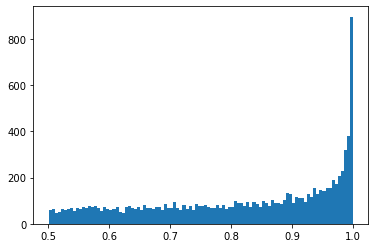

In [46]:
#noexport
lam = Beta(0.5, 0.5).sample((10000,))
lam = torch.stack([lam, 1-lam], 1)
lam = lam.max(1)[0].numpy()
_ = plt.hist(lam, bins=100)

In [47]:
class MyMixUp(Callback):
    run_after,run_valid = [Normalize],False
    def __init__(self, alpha=0.4): 
        self.distrib = Beta(tensor(alpha), tensor(alpha))

    def before_batch(self):
        lam = self.distrib.sample((self.y.size(0),)).squeeze().to(self.y.device)
        lam = torch.stack([lam, 1-lam], 1)
        lam = lam.max(1)[0]
        shuffle = torch.randperm(self.y.size(0)).to(self.y.device)
        self.learn.xb = (*self.xb, shuffle, lam)
        self.learn.yb = (*self.yb, shuffle, lam)

In [48]:
class GradientClipping(Callback):
    "Gradient clipping during training."
    def __init__(self, clip:float = 0.):
        self.clip = clip

    def after_backward(self, **kwargs):
        "Clip the gradient before the optimizer step."
        if self.clip: nn.utils.clip_grad_norm_(self.learn.model.parameters(), self.clip)

# Model

In [49]:
class TutorNet(nn.Module):
    def __init__(self, emb_szs, tag_emb_szs, emb_do, n_cont, trf_dim, trf_enc, trf_dec, trf_heads, trf_do, trf_act):
        super().__init__()
        self.nhead,self.trf_dim = trf_heads, trf_dim
        
        tag_emb_szs =(tag_emb_szs[0]+1, trf_dim)

        self.embeds    = nn.ModuleList([nn.Sequential(nn.Embedding(ni+1, nf, max_norm=1.),nn.Linear(nf, trf_dim)) 
                                        for ni, nf in emb_szs])
        self.tagembeds = nn.EmbeddingBag(*tag_emb_szs, max_norm=1., mode='sum')
        self.conts     = nn.Linear(n_cont, trf_dim)
            
        self.trafo = nn.Transformer(
            d_model = trf_dim,
            nhead = trf_heads,
            num_encoder_layers = trf_enc,
            num_decoder_layers = trf_dec,
            dim_feedforward = trf_dim*4,
            dropout = trf_do,
            activation = trf_act,
        )

        self.mlp = nn.Linear(trf_dim, 6)
        
    def forward(self, x_mask, x_cat, x_cont, x_tags, x_tagw, shuffle=None, lam=None):
        b, sl, catf, contf, tagsf = (*x_cat.shape, x_cont.shape[2], x_tags.shape[2])
        
        x_cat  += 1
        x_tags += 1
    
        # compute masks
        causal_mask  = torch.triu(torch.ones(1,sl, sl,dtype=torch.bool,device=x_cat.device), diagonal=1).expand(b,-1,-1)
        x_tci   = x_cat[...,Cats.task_container_id]
        x_tci_s = torch.zeros_like(x_tci)
        x_tci_s[...,1:] = x_tci[...,:-1]
        enc_container_aware_mask =  (x_tci.unsqueeze(-1) == x_tci_s.unsqueeze(-1).permute(0,2,1)) | causal_mask
        dec_container_aware_mask = ~(x_tci.unsqueeze(-1) == x_tci.unsqueeze(-1).permute(0,2,1))   & causal_mask

        padding_mask = x_mask 
                
        # encoder x (shifted q & a)
        enc_cat  = torch.zeros_like(x_cat)
        enc_cont = torch.zeros_like(x_cont)
        enc_tags = torch.zeros_like(x_tags)
        enc_tagw = torch.zeros_like(x_tagw)
        
        enc_cat[:,1:]  = x_cat[:,:-1]
        enc_cont[:,1:] = x_cont[:,:-1]
        enc_tags[:,1:] = x_tags[:,:-1]
        enc_tagw[:,1:] = x_tagw[:,:-1]
        
        # decoder x (nonshifted q)
        dec_cat  = x_cat
        dec_cont = x_cont
        dec_tags = x_tags
        dec_tagw = x_tagw

        # hide correct answer and user answered correctly from decoder
        dec_cat[...,Cats.answered_correctly] = 0
        dec_cat[...,Cats.user_answer] = 0
        dec_cat[...,Cats.qhe] = 0
        dec_cont[...,Conts.qet] = 0
        dec_cont[...,Conts.qet_log] = 0
        
        # print(enc_cont.shape)
        enc_cat  =  enc_cat.view(b * sl, catf)   # b*sl, catf
        enc_tags = enc_tags.view(b * sl, tagsf) # b*sl, tagsf
        enc_tagw = enc_tagw.view(b * sl, tagsf) # b*sl, tagsf

        dec_cat  =  dec_cat.view(b * sl, catf)   # b*sl, catf
        dec_tags = dec_tags.view(b * sl, tagsf) # b*sl, tagsf
        dec_tagw = dec_tagw.view(b * sl, tagsf) # b*sl, tagsf
        
        # embed categorical vars
        enc = torch.mean(torch.stack([
            *[ e(enc_cat[:,i]) for i, e in enumerate(self.embeds) ],
            self.tagembeds(enc_tags, per_sample_weights=enc_tagw),
            self.conts(enc_cont).view(-1,self.trf_dim)
        ]),dim=0)
        
        dec = torch.mean(torch.stack([
            *[ e(dec_cat[:,i]) for i, e in enumerate(self.embeds) ],
            self.tagembeds(dec_tags, per_sample_weights=dec_tagw),
            self.conts(dec_cont).view(-1,self.trf_dim)
        ]),dim=0)
        
        enc = enc.view(b, sl, self.trf_dim)           # b, sl, sum of cat, cont and tag ftrs
        dec = dec.view(b, sl, self.trf_dim)           # b, sl, sum of cat, cont and tag ftrs

        if shuffle is not None:
            enc = torch.lerp(enc, enc[shuffle], lam.view(lam.shape[0], 1, 1))
            dec = torch.lerp(dec, dec[shuffle], lam.view(lam.shape[0], 1, 1))
            padding_mask = None
            enc_container_aware_mask = dec_container_aware_mask = causal_mask | causal_mask[shuffle]
        
        enc = enc.permute(1, 0, 2)          # sl, b, tf (torchformer input)
        dec = dec.permute(1, 0, 2)          # sl, b, tf

        expand_nheads = lambda t: t.unsqueeze(1).expand(t.shape[0],self.nhead,-1,-1).reshape(-1,*t.shape[-2:])
        
        o = self.trafo(
            enc, 
            dec, 
            src_mask = expand_nheads(enc_container_aware_mask),
            tgt_mask = expand_nheads(dec_container_aware_mask),
            memory_mask = expand_nheads(enc_container_aware_mask),
            src_key_padding_mask = padding_mask,
            tgt_key_padding_mask = padding_mask,
            memory_key_padding_mask = padding_mask,
        )                                   # sl, b, tf
        o = o.permute(1, 0, 2)              # b, sl, tf
        o = self.mlp(o)                     # b, sl, of (of=2)
        #print(o)
        return o

In [50]:
emb_szs = list(zip(meta.n_emb.values(), meta.emb_dim.values()))
tag_emb_szs = meta.tags_n_emb, meta.tags_emb_dim

In [51]:
model = TutorNet(emb_szs, tag_emb_szs, None, len(meta.cont_names), 
                 H.trf_dim, H.trf_enc, H.trf_dec, H.trf_heads, H.trf_do, H.trf_act)

# T-Fixup init

1. Apply Xavier initialization for all parameters excluding input embeddings. Use Gaussian initialization $N(0,d^{-\frac{1}{2}})$ for input embeddings where d is the embedding dimension.

2. Scale $v_{d}$ and $w_{d}$ matrices in each decoder attention block, weight matrices in each decoder MLP block and input embeddings $x$ and $y$ in encoder and decoder by $(9N)^{−\frac{1}{4}}$: [code](https://github.com/layer6ai-labs/T-Fixup/blob/f1fae213ce7b48829f81632d0c96bb039b7c450e/fairseq/modules/transformer_layer.py#L161), [code](https://github.com/layer6ai-labs/T-Fixup/blob/f1fae213ce7b48829f81632d0c96bb039b7c450e/fairseq/models/transformer.py#L378), [code](https://github.com/layer6ai-labs/T-Fixup/blob/f1fae213ce7b48829f81632d0c96bb039b7c450e/fairseq/models/transformer.py#L604)

3. Scale $v_{e}$ and $w_{e}$ matrices in each encoder attention block and weight matrices in each encoder MLP block by $0.67N^{−\frac{1}{4}}$: [code](https://github.com/layer6ai-labs/T-Fixup/blob/f1fae213ce7b48829f81632d0c96bb039b7c450e/fairseq/modules/transformer_layer.py#L36)

In [52]:
def trunc_normal_(x, mean=0., std=1.):
    "Truncated normal initialization (approximation)"
    # From https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/12
    return x.normal_().fmod_(2).mul_(std).add_(mean)

In [53]:
if H.tfixup:
    for n,p in model.named_parameters():
        if re.match(r'.*bias$|.*bn\.weight$|.*norm.*\.weight',n): continue
        gain = 1.
        if re.match(r'.*decoder.*',n): 
            gain = (9*H.trf_dec)**(-1./4.)
            if re.match(f'.*in_proj_weight$',n): gain *= (2**0.5)
        elif re.match(r'.*encoder.*',n): 
            gain = 0.67*(H.trf_enc**(-1./4.))
            if re.match(f'.*in_proj_weight$',n): gain *= (2**0.5)
        if re.match(r'^embeds|^tagembeds', n): 
            trunc_normal_(p.data,std=(4.5*(H.trf_enc+H.trf_dec))**(-1./4.)*H.trf_dim**(-0.5))
        else:                                  
            nn.init.xavier_normal_(p,gain=gain)

In [54]:
if H.tfixup:
    class MyModelPatcher(ModelPatcher):
        def new_child_module(self, child_module_name, child_module, patch_info): return nn.Identity()
    mp = MyModelPatcher()
    mp.add_pattern(r".*norm\d?.*",{})
    mp.patch_model(model)

In [55]:
#noexport
model

TutorNet(
  (embeds): ModuleList(
    (0): Sequential(
      (0): Embedding(3, 1, max_norm=1.0)
      (1): Linear(in_features=1, out_features=512, bias=True)
    )
    (1): Sequential(
      (0): Embedding(5, 3, max_norm=1.0)
      (1): Linear(in_features=3, out_features=512, bias=True)
    )
    (2): Sequential(
      (0): Embedding(9767, 274, max_norm=1.0)
      (1): Linear(in_features=274, out_features=512, bias=True)
    )
    (3): Sequential(
      (0): Embedding(6, 4, max_norm=1.0)
      (1): Linear(in_features=4, out_features=512, bias=True)
    )
    (4): Sequential(
      (0): Embedding(420, 47, max_norm=1.0)
      (1): Linear(in_features=47, out_features=512, bias=True)
    )
    (5): Sequential(
      (0): Embedding(9, 5, max_norm=1.0)
      (1): Linear(in_features=5, out_features=512, bias=True)
    )
    (6): Sequential(
      (0): Embedding(4, 3, max_norm=1.0)
      (1): Linear(in_features=3, out_features=512, bias=True)
    )
    (7): Sequential(
      (0): Embedding(135

In [56]:
dls = dls.cuda()
model = model.cuda()

In [57]:
@delegates(Lamb)
def ranger_lamb(p, lr, mom=0.95, wd=0.01, eps=1e-6, **kwargs):
    return Lookahead(Lamb(p, lr=lr, mom=mom, wd=wd, eps=eps, **kwargs))

In [58]:
learn = Learner(
    dls,
    model,
    loss_func=ua_loss_func,
    opt_func=partial(globals()[H.opt],**H.opt_kwargs),
    moms = H.moms,
    metrics=[
        LBMetric(loss_func, 'acc_valid_loss'),
        LBMetric(roc_auc, 'acc_roc_auc'),
    ],
)

In [59]:
f_fp16 = getattr(learn,H.fp16,None)
if f_fp16: f_fp16()

In [60]:
def rank0_only(func, *args, **kwargs):
    "Execute `func` in the Rank-0 process first, then in other ranks in parallel."
    if args or kwargs: func = partial(func, *args, **kwargs)
    dummy_l = Learner(DataLoaders(device='cpu'), nn.Linear(1,1), loss_func=lambda: 0)
    res = None
    with dummy_l.distrib_ctx():
        if not rank_distrib(): res = func()
        distrib_barrier()
    return res

In [61]:
@patch
def load(learn:Learner,fn,with_opt=False):
    def __inner(learn:Learner,fn,with_opt=False):
        m_dict = torch.load(f"{(Path(learn.model_dir) / fn)}.pth")#['model']
        ks = []
        for attempts in range(2):
            try:
                res = learn.model.load_state_dict(m_dict,strict=False)
                print(f"Loaded {fn} ignoring: {' '.join(ks)} and {res}")
                break
            except Exception as e:
                for k in [m[1] for m in [re.match(r"^.*mismatch for ([\w\.]+):",l) for l in str(e).split("\n")] if m is not None]:
                    m_dict.pop(k,None)
                    ks.append(k)
        return learn
    return rank0_only(__inner, learn, fn, with_opt)

# Load model

In [62]:
if H.load:
    learn.load(H.load, with_opt=False)
    print(f"Loaded: {H.load}")

In [63]:
if H.clip: 
    learn.add_cb(GradientClipping(H.clip))
    print('clip on')

In [64]:
if H.local_rank is not None: 
    learn.to_distributed(H.local_rank)
    print('local_rank on')
if H.mixup: 
    learn.add_cb(MyMixUp(0.5))
    print('mixup on')

In [65]:
if H.validate:
    res = learn.validate()
    print(f"CV: {res[-1]}")

In [66]:
#noexport
learn.summary()

TutorNet (Input shape: 48 x 500)
Layer (type)         Output Shape         Param #    Trainable 
                     48 x 1              
Embedding                                 3          True      
____________________________________________________________________________
                     48 x 512            
Linear                                    1024       True      
____________________________________________________________________________
                     48 x 3              
Embedding                                 15         True      
____________________________________________________________________________
                     48 x 512            
Linear                                    2048       True      
____________________________________________________________________________
                     48 x 274            
Embedding                                 2676158    True      
_________________________________________________________________

# Train

In [67]:
#noexport
#learn.lr_find()

In [68]:
#noexport
#learn.recorder.plot_lr_find(skip_end=10)

In [69]:
#short_cb = learn.add_cb(ShortEpochCallback(pct=0.001))

In [70]:
learn.add_cb(SaveModelCallback(monitor='acc_roc_auc', comp=np.greater, fname=f'best{H.model}'))

In [71]:
print(H.fit, H.epochs, H.lr, H.fit_kwargs)

fit_flat_cos 5 0.003 {'pct_start': 0.5, 'div_final': 100.0}


In [72]:
#noexport
syn_learn = synth_learner()
getattr(syn_learn,H.fit)(H.epochs, H.lr,**H.fit_kwargs)

epoch,train_loss,valid_loss,time
0,17.966696,14.766358,00:00
1,12.346977,4.096241,00:00
2,8.069063,0.411127,00:00
3,5.452080,0.022483,00:00
4,3.890170,0.013391,00:00


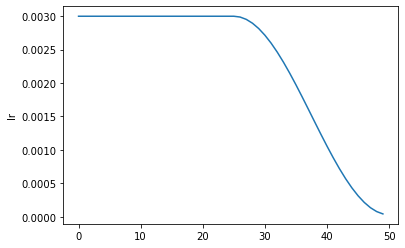

In [73]:
#noexport
syn_learn.recorder.plot_sched()

In [74]:
H

- model: 210105
- data: 210101b
- load: None
- validate: False
- chunk_size: 500
- n_chunks: 1
- bs: 48
- workers: 8
- valid_pct: 0.025
- trf_dim: 512
- trf_enc: 4
- trf_dec: 4
- trf_heads: 4
- trf_do: 0.1
- trf_act: gelu
- lr: 0.003
- clip: 0.0
- moms: (0.95, 0.85, 0.95)
- epochs: 5
- tfixup: True
- mixup: False
- opt: ranger_lamb
- opt_kwargs: 

- fit: fit_flat_cos
- fit_kwargs: 
  - pct_start: 0.5
  - div_final: 100.0
- fp16: to_fp16
- loss: ce
- wua: 0.0
- pad: r
- local_rank: None

In [75]:
#learn.fit_flat_cos(H.epochs, H.lr,**H.fit_kwargs)

In [76]:
print(f"Fitting {H.local_rank}")
getattr(learn,H.fit)(H.epochs, H.lr,**H.fit_kwargs)

Fitting None


epoch,train_loss,valid_loss,acc_valid_loss,acc_roc_auc,time
0,0.516579,0.515066,0.510675,0.793318,1:14:32
1,0.510655,0.510763,0.506494,0.797913,1:14:38
2,0.508685,0.506038,0.501583,0.802250,1:14:47
3,0.501284,0.501635,0.497102,0.806428,1:15:05
4,0.498384,0.499137,0.494578,0.808618,1:14:41


Better model found at epoch 0 with acc_roc_auc value: 0.7933179432288439.
Better model found at epoch 1 with acc_roc_auc value: 0.7979130787255149.
Better model found at epoch 2 with acc_roc_auc value: 0.8022501124717482.
Better model found at epoch 3 with acc_roc_auc value: 0.8064278025877302.
Better model found at epoch 4 with acc_roc_auc value: 0.8086181047023688.
Loaded best210105 ignoring:  and <All keys matched successfully>


In [77]:
#noexport
learn.recorder.values

[(#4) [0.5165794491767883,0.5150657296180725,0.5106747150421143,0.7933179432288439],
 (#4) [0.5106547474861145,0.5107629299163818,0.5064940452575684,0.7979130787255149],
 (#4) [0.5086852312088013,0.5060381889343262,0.5015827417373657,0.8022501124717482],
 (#4) [0.5012843012809753,0.5016353130340576,0.49710196256637573,0.8064278025877302],
 (#4) [0.4983840584754944,0.4991369843482971,0.4945776164531708,0.8086181047023688]]

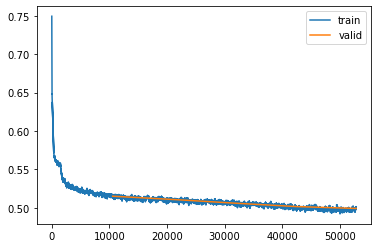

In [78]:
#noexport
learn.recorder.plot_loss()